In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
import pandas as pd
import os

In [137]:
FIN_PATH = "/home/peter/Documents/uni/FIN-Dataset"
scenes = ["hallway", "auditorium", "office", "conferenceRoom"]
algorithms = ["draco", "draco_lossless", "pccomp","tmc3","sparsepcgc"]
scenes, algorithms

(['hallway', 'auditorium', 'office', 'conferenceRoom'],
 ['draco', 'draco_lossless', 'pccomp', 'tmc3', 'sparsepcgc'])

In [14]:
def gather_dfs(scene: str):
    root = os.path.join(FIN_PATH, scene)
    qual_data = dict()
    sim_data = dict()
    for subdir in os.listdir(root):
        if not os.path.isdir(os.path.join(root, subdir)) or subdir == "GT":
            continue
        metrics_path = os.path.join(root, subdir, "metrics", f"{subdir}-{scene}.csv")
        sim_path = os.path.join(root, subdir, "metrics", f"{subdir}-{scene}-sim.csv")
        metrics = pd.read_csv(metrics_path)
        sim = pd.read_csv(sim_path)
        sim["Cloud Size"] = metrics["num_points"]
        metrics["Symmetric Similarity"] = sim["Symmetric Similarity"]
        qual_data[subdir] = metrics
        sim_data[subdir] = sim
    return qual_data, sim_data

In [246]:
def gather_dfs_local():
    root = "metrics"
    qual_data = dict()
    sim_data = dict()
    for scene in scenes:
        print(scene)
        if scene not in qual_data:
            qual_data[scene] = dict()
            sim_data[scene] = dict()
        for algorithm in algorithms:
            print("\t"+algorithm)
            if algorithm == "sparsepcgc" and scene != "hallway":
                continue
            metrics_path = os.path.join(root, f"{algorithm}-{scene}-qual.csv")
            sim_path = os.path.join(root, f"{algorithm}-{scene}-sim.csv")
            metrics = pd.read_csv(metrics_path)
            sim = pd.read_csv(sim_path)
            sim["Cloud Size"] = metrics["num_points"]
            sim['Index'] = sim['Filename'].str.extract(r'T(\d+)').astype(int)
            sim = sim.sort_values(by='Index')
            sim = sim.set_index(sim["Index"])
            sim = sim.drop(columns=['Index'])
            sim.to_csv(sim_path,index=False)
            metrics["Symmetric Similarity"] = sim["Symmetric Similarity"]
            sim_data[scene][algorithm] = sim
            qual_data[scene][algorithm] = metrics
    return qual_data, sim_data

In [247]:
scene_qual_data, scene_sim_data = gather_dfs_local()

hallway
	draco
	draco_lossless
	pccomp
	tmc3
	sparsepcgc
auditorium
	draco
	draco_lossless
	pccomp
	tmc3
	sparsepcgc
office
	draco
	draco_lossless
	pccomp
	tmc3
	sparsepcgc
conferenceRoom
	draco
	draco_lossless
	pccomp
	tmc3
	sparsepcgc


,Filename,Symmetric Similarity,Cloud Size
0,hallway-T0,0.999055,108
1,hallway-T1,0.997570,330
81,hallway-T2,0.995373,466560
92,hallway-T3,0.985614,526020
103,hallway-T4,0.972539,583065
...,...,...,...
73,hallway-T164,0.843523,410136
74,hallway-T165,0.843524,416496
75,hallway-T166,0.843821,422571
76,hallway-T167,0.843941,432636


In [227]:
def merge(exclude_scene: list[str]=[],exclude_algo: list[str]=[]):
    global scene_qual_data, scenes
    algo_all = dict()
    for scene in scenes:
        if scene in exclude_scene:
            continue
        for algo, df in scene_qual_data[scene].items():
            if algo in exclude_algo:
                continue
            if not algo in algo_all:
                algo_all[algo] = df
            else:
                algo_all[algo] = pd.concat([algo_all[algo],df])
    return algo_all


In [273]:
all_scenes_all_algos = merge()
hallway_sparsepcgc = merge(exclude_algo=["draco", "draco_lossless", "tmc3","sparsepcgc"])
colors = {"draco": "tab:blue", "draco_lossless":"tab:green", "pccomp":"tab:red", "tmc3": "tab:cyan", "sparsepcgc":"tab:orange"}


In [275]:
def plot_qual(algorith_map: dict[str, pd.DataFrame], title: str):
    fig, axs = plt.subplots(2,2, figsize=(8, 8))
    ls = []
    algorithms = []
    for algorithm, df in algorith_map.items():
        algorithms.append(algorithm)
        bpps = df["bpp"]
        enc_size = df["enc_file_size_bits"]/8000
        time_enc = df["time_enc_ns"]/10**9
        time_dec = df["time_dec_ns"]/10**9
        points = df["num_points"] / 10**5
        l = axs[0, 0].scatter(points, enc_size, s=1, color=colors[algorithm])
        ls.append(l)
        axs[0, 0].set_ylabel("Enc. File Size (kb)")
        axs[0, 1].scatter(points, time_enc, s=1, color=colors[algorithm])
        axs[0, 1].set_ylabel("Enc. Time (s)")
        axs[0, 1].set_yscale("log")
        axs[1, 0].set_yscale("log")
        axs[0, 1].set_yticks([0.01, 0.1, 1, 4,])
        axs[0, 1].set_ylim(0.01, 5)
        axs[1, 0].set_ylim(0.001, 5)
        axs[1, 0].scatter(points, time_dec, s=1, color=colors[algorithm])
        axs[1, 0].set_ylabel("Dec. Time (s)")
        axs[1, 1].scatter(points, bpps, s=1, label=algorithm, color=colors[algorithm])
        axs[1, 1].set_ylabel("Bits per Point")
        axs[1, 1].set_ylim(2, 19)

    for ax in axs.flat:
        ax.set_xlabel("#Points ($\\times 10^5$)")
        ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
        ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
    lgnd = fig.legend(ls, algorithms, loc="center", ncols=(5))
    for handle in lgnd.legend_handles:
        handle.set_sizes([12.0])
    fig.tight_layout(pad=2.5)
    fig.savefig(f"figures/{title}.svg", format="svg")
    return fig

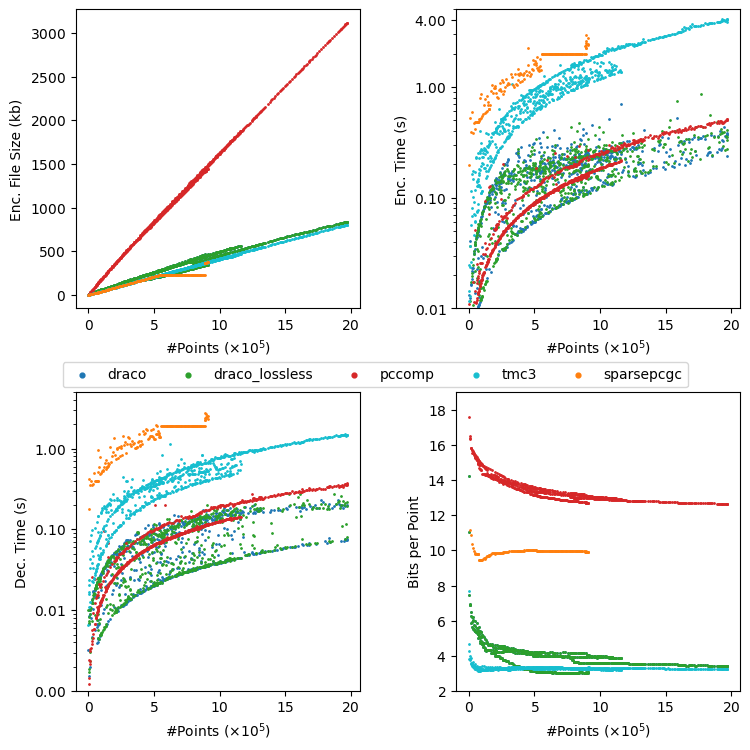

In [277]:
fig_qual_no_hw = plot_qual(all_scenes_all_algos, "all_scenes_all_algos")
# fig_qual_hw = plot_qual(hallway_sparsepcgc, "hallway_sparsepcgc")

In [ ]:
x = scene_sim_data["auditorium"]["draco"]
x.set_i
x

,Filename,Symmetric Similarity,Cloud Size
0,auditorium-T0,0.987978,2550
1,auditorium-T1,0.981712,13563
112,auditorium-T2,0.975873,816939
184,auditorium-T3,0.972401,1280682
195,auditorium-T4,0.969927,1343466
...,...,...,...
175,auditorium-T256,0.872685,1254897
176,auditorium-T257,0.872623,1261704
177,auditorium-T258,0.872614,1249776
178,auditorium-T259,0.872606,1256208


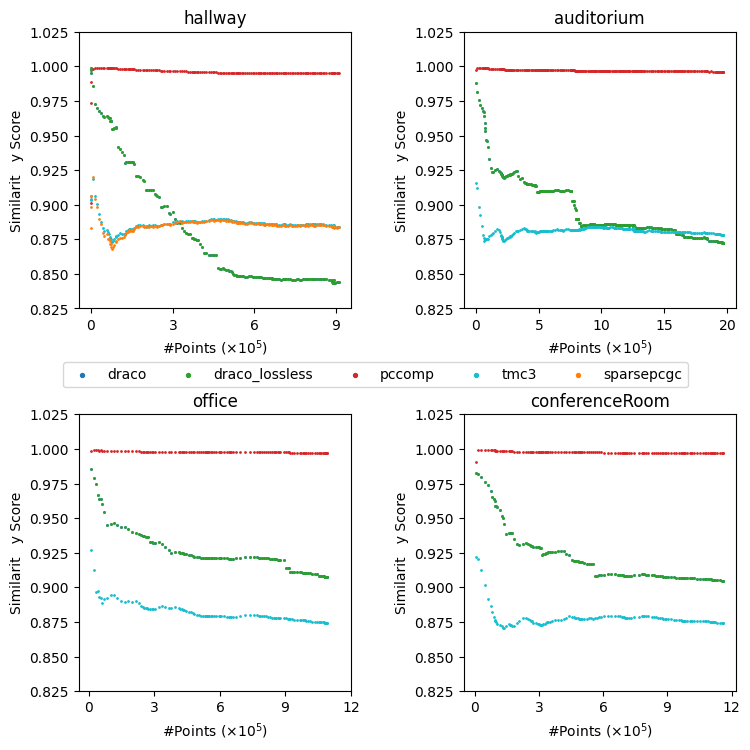

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8,8))
ls = []
for i, scene in enumerate(scenes):
    for algo, df in scene_sim_data[scene].items():
        if algo == "sparsepcgc" and scene != "hallway":
            continue
        similarity = df["Symmetric Similarity"]    
        cloud_size = df["Cloud Size"] / 10**5
        l = axs.flat[i].scatter(cloud_size, similarity, s=1,color=colors[algo])
        ls.append(l)
        if scene == "hallway":
            axs.flat[i].set_xticks([0, 3, 6,  9])
        if scene == "auditorium":
            axs.flat[i].set_xticks([0, 5, 10, 15, 20])
        if scene == "office":
            axs.flat[i].set_xticks([0, 3, 6,  9, 12])
        if scene == "conferenceRoom":
            axs.flat[i].set_xticks([0, 3, 6, 9, 12])
        axs.flat[i].set_ylim([0.825, 1.025])
        axs.flat[i].set_xlabel("#Points ($\\times 10^5$)")
        axs.flat[i].xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
        axs.flat[i].set_title(scene)
        axs.flat[i].set_ylabel("Similarit   y Score")
lgnd = fig.legend(ls, algorithms, loc="center", ncols=(5))
for handle in lgnd.legend_handles:
    handle.set_sizes([8.0])
fig.tight_layout(pad=2.5)

plt.show()
fig.savefig("figures/similarity.svg", format="svg")

In [267]:
for algo, df in algo_all.items():
    similarity = df["Symmetric Similarity"]    
    bpp = df["bpp"]    
    filesize = df["enc_file_size_bits"]  / 8000  
    avg_sim = np.round(np.average(similarity), decimals=3)
    avg_bpp = np.round(np.average(bpp), 3)
    avg_fs = np.round(np.average(filesize), 3)
    avg_enc = int(np.round(np.average(np.divide(df["time_enc_ns"], df["num_points"])), 3))
    avg_dec = int(np.round(np.average(np.divide(df["time_dec_ns"], df["num_points"])), 3))
    avg_total = int(np.round(avg_enc+avg_dec))
    print(algo)
    print(f"\tAvg. similarity score:  {avg_sim}")
    print(f"\tAvg. bpp:                     {avg_bpp}")
    print(f"\tAvg. file size(kb):       {avg_fs}")
    print(f"\tAvg. enc:                     {avg_enc} ns")
    print(f"\tAvg. dec:                     {avg_dec} ns")
    print(f"\tAvg. total time:           {avg_total} ns")

draco
	Avg. similarity score:  0.903
	Avg. bpp:                     4.025
	Avg. file size(kb):       324.573
	Avg. enc:                     396 ns
	Avg. dec:                     220 ns
	Avg. total time:           616 ns
draco_lossless
	Avg. similarity score:  0.903
	Avg. bpp:                     4.025
	Avg. file size(kb):       324.573
	Avg. enc:                     480 ns
	Avg. dec:                     309 ns
	Avg. total time:           789 ns
pccomp
	Avg. similarity score:  0.997
	Avg. bpp:                     13.541
	Avg. file size(kb):       1145.123
	Avg. enc:                     281 ns
	Avg. dec:                     173 ns
	Avg. total time:           454 ns
tmc3
	Avg. similarity score:  0.882
	Avg. bpp:                     3.315
	Avg. file size(kb):       289.168
	Avg. enc:                     1925 ns
	Avg. dec:                     938 ns
	Avg. total time:           2863 ns
sparsepcgc
	Avg. similarity score:  0.885
	Avg. bpp:                     9.868
	Avg. file size(kb):       1

In [10]:
per_scene = dict()
for qual in os.listdir("metrics"):
    if "qual" not in qual:
        continue
    algo, scene, _ = qual.split("-")
    if scene not in per_scene:
        per_scene[scene] = dict()
    per_scene[scene][algo] = pd.read_csv(os.path.join("metrics", qual))
    

In [192]:
hallway_all = dict()
for algo, df in scene_qual_data["hallway"].items():
    if not algo in hallway_all:
        hallway_all[algo] = df
    else:
        hallway_all[algo] = pd.concat([hallway_all[algo],df])

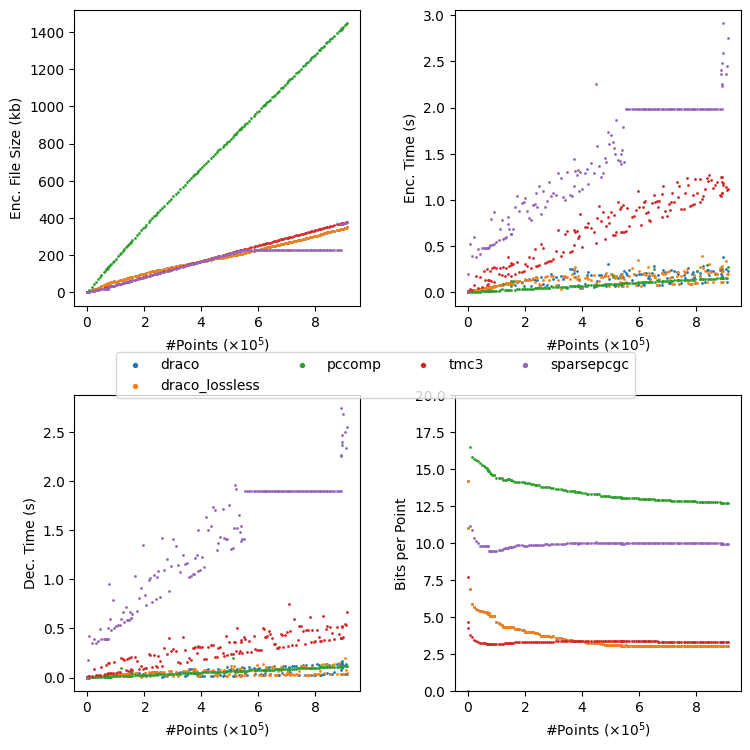

In [12]:
fig, axs = plt.subplots(2,2, figsize=(8,8))
ls = []
import matplotlib.ticker as mtick
algorithms = []
for algorithm, df in hallway_all.items():
    algorithms.append(algorithm)
    bpps = df["bpp"]
    enc_size = df["enc_file_size_bits"]/8000
    time_enc = df["time_enc_ns"]/10**9
    time_dec = df["time_dec_ns"]/10**9
    points = df["num_points"] / 10**5
    l = axs[0, 0].scatter(points, enc_size, s=1)
    ls.append(l)
    axs[0, 0].set_ylabel("Enc. File Size (kb)")
    axs[0, 1].scatter(points, time_enc, s=1)
    axs[0, 1].set_ylabel("Enc. Time (s)")
    axs[1, 0].scatter(points, time_dec, s=1)
    axs[1, 0].set_ylabel("Dec. Time (s)")
    axs[1, 1].scatter(points, bpps, s=1, label=algorithm)
    axs[1, 1].set_ylabel("Bits per Point")
    axs[1, 1].set_ylim(0, 20)
for ax in axs.flat:
    ax.set_xlabel("#Points ($\\times 10^5$)")
    ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
lgnd = fig.legend(ls, algorithms, loc="center", ncols=(4))
for handle in lgnd.legend_handles:
    handle.set_sizes([8.0])
fig.tight_layout(pad=2.5)
plt.show()